<div align="right">
  Christopher Lüken-Winkels, Lukas Blecher
</div>
# Exercise 1b
## 2 Asymptotic error of the nearest neighbor classifier for the toy example from exercise 1

$$\begin{align}
p_∞(error|X) = 1 -\sum_{k=1} p^∗ (Y = k | X)^2 &&&& \text{(1)}\\
p^*(Y=1|X)=X&&&& \text{(2)}\\
p^*(Y=0|X)=1-X&&&& \text{(3)}\\
p(X)=1&&&& \text{(4)}
\end{align}$$
Now solve the following integral: $$p_\infty(\text{error})=\int p_\infty(\text{error}|X)p(X)dX \stackrel{\text{(1)}}{=}\int \left( \sum_{k=1} p^*(Y=k|X)^2 \right)p(X)dX \stackrel{\text{(2),(3),(4)}}{=}\int \left( 1-X^2-X^2+2X-1\right)dX= \int_0^1 \left(2X-2X^2\right)dX=\left(X^2-\frac23X^3\right) \biggr\rvert^1_0=1-\frac23=\frac13$$
In exersize 1 we already approximated an error of about 33% for training sets of size 100, which confirms the theoretical solution.

<span style =" color : green ;font-weight : bold ">The derivation and calculation is the same.</span>

## 3 Nearest Neighbor Classification on Real Data
### 3.1 Exploring the Data

In [79]:
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt
import numpy as np
import itertools
digits = load_digits ()
print ( digits.keys () )
data = digits ["data"]
images = digits ["images"]
target = digits ["target"]
target_names = digits ["target_names"]
print ( data.dtype )
#get an image of a random "3":
threes=images[target==3] #could also use data[index].reshape((8,8)) 
img=threes[np.random.randint(len(threes))]

dict_keys(['data', 'target', 'target_names', 'images', 'DESCR'])
float64


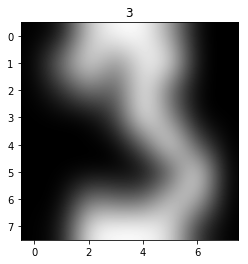

In [80]:
assert 2 == len( img.shape )
plt.figure ()
plt.gray ()
plt.imshow (img , interpolation ="bicubic") # also try interpolation =" bicubic "
plt.title('3')
plt.show ()

<span style =" color : green ;font-weight : bold ">We tried out both interpolation modes but stuck with "bicubic". Also wie selected a random three out of the data set.</span>

In [81]:
from sklearn import model_selection
X_all = data[7:] #needs to be divisible by 10 for later to work
y_all = target[7:]
X_train , X_test , y_train , y_test =\
model_selection.train_test_split ( digits.data , digits.target ,test_size = 0.4 , random_state = 0)

### 3.2 Distance function computation using loops
$$\text{dist:}\ {\rm I\!R}^{N \times D} \times {\rm I\!R}^{M \times D} \rightarrow {\rm I\!R}^{N \times M}$$ with $$N \text{: Length of training set}\\M \text{: Lenght of test set}\\D \text{: Number of pixels} = 64$$

In [82]:
def dist_loop(training, test):
    d=[] #save distances in this matrix
    #now: fill matrix line by line
    for i in range(len(training)):
        line=[] 
        #fill line for line with the distances
        for j in range(len(test)):
            line.append(np.sqrt(np.sum(np.square(test[j]-training[i]))))
        d.append(line)
    return np.array(d)

<span style =" color : green ;font-weight : bold ">We used a python list instead of a pre-initialized numpy vector of the size $N\times M$. But besides that the complexity should be about the same. </span>

### 3.3 Distance function computation using vectorization

In [83]:
def dist_vec(training, test):
    #adding a new dimension to sum over (pixels) and calculate the difference to the test set in each instance
    return np.sqrt(np.sum(np.square(training[:,None]-test),axis=2))

<span style =" color : green ;font-weight : bold ">We found a similar way to compute the distance matrix. Instead of using $\texttt{numpy.expand_dims}$ we used an equivalent of $\texttt{numpy.newaxis}=\texttt{None}$. In the documentation you can also find "y = np.expand_dims(x, axis=1)  # Equivalent to x[:,np.newaxis]". So we did exactly the same.</span>

In [84]:
%timeit dist_loop(X_test,X_train)

1 loop, best of 3: 10.4 s per loop


In [85]:
%timeit dist_vec(X_test,X_train)

1 loop, best of 3: 773 ms per loop


In [86]:
#check if both function even do the same
np.array_equal(dist_vec(X_test,X_train),dist_loop(X_test,X_train))

True

As we can see the vectorized solution is way faster than the looped version and gives the same result.

<span style =" color : green ;font-weight : bold ">Our both functions give the same result. The solution used the same numpy function as us but the result there was $\texttt{False}$. That's the only difference.</span >

### 3.4 Implement the k-nearest neighbor classifier

In [87]:
#define the subset of X_train
subX_train=X_train[(y_train==3) | (y_train==9)] #only 3's and 9's are in the subsets
subX_test=X_test[(y_test==3) | (y_test==9)]
subY_train=y_train[(y_train==3) | (y_train==9)]
subY_test=y_test[(y_test==3) | (y_test==9)]

In [88]:
#nearest neighbor classifier
def NN(k,training,test,trainingLabel,testLabel):
    #calculate the distance matrix
    distance=dist_vec(training,test)
    guess=[]
    for i in range(len(test)):
        #get indices of smallest k distances of each column
        sorting=np.argsort(distance,axis=0).T[i][:k]
        #take the mean of all neighbors and see what integer is the most likley
        guess.append(round(np.mean(trainingLabel[sorting])))
    error=1-np.count_nonzero(np.equal(guess,testLabel))/len(testLabel)
    return error,np.array(guess)

<span style =" color : green ;font-weight :bold ">We made an error here. Instead of determing the highest contributer we took all the contributers and took the mean as best guess. But clearly this is wrong. Besides that we did almost the same calculations as in the solution. We returned the error and it's std instead of the guesses.</span >

try for $k \in [ 1, 3, 5, 9, 17,33]$

In [89]:
err=[]
for k in [1,3,5,9,17,33]:
    errK,result=NN(k,subX_train,subX_test,subY_train,subY_test)
    err.append(errK)
print(np.mean(err),np.std(err))

0.178240740741 0.147350282063


So in average we get an error rate for $(17.8\pm 14.7)$%

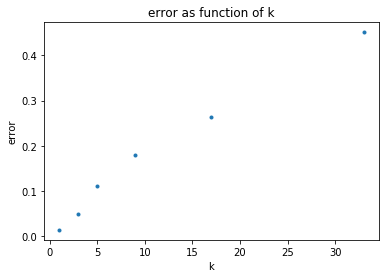

In [90]:
plt.plot([1,3,5,9,17,33],err,'.',label='error rate')
plt.xlabel('k')
plt.ylabel('error')
plt.title('error as function of k')
plt.show()

We can see that the error is growing with $k$.


<span style =" color : green ;font-weight : bold ">The plot looks very similar to the one in the solution only the y-scale is different. Instead of 1.2% we got a maximum error of ~40%. This can be traced to our implementation of the NN classifier. Also we did not print out a confusion matrix.</span >

### 4 Cross-validation

In [91]:
from numpy import random as rnd

def split_folds(data, target, L):   
    #shuffle target and data in unison
    permutation = rnd.permutation(len(data))
    data,target = data[permutation],target[permutation]
    return np.array(np.array_split(data,L)),np.array(np.array_split(target,L))

<span style =" color : green ;font-weight : bold ">We wrote the function $\texttt{splif_folds(data,target,L)}$ as it was asked. It works exaclty like the splitting part in the solutions function $\texttt{cross_validate}$. </span >

In [92]:
def cross_val(data,target,L,k):   #only works if len(data)%L == 0
    if len(data)%L!=0:
        raise ValueError('Only works with denominators of the data length')
    #start list for error values
    Err = []
    #split data
    X_folds,Y_folds = split_folds(data,target,L)
    #use each fold as test data once and the remaining folds as training set
    for i in range(L):
        X_test,Y_test = X_folds[i],Y_folds[i]
        X_train,Y_train = np.delete(X_folds,i,axis=0),np.delete(Y_folds,i,axis=0).flatten() #training set without test set
        X_train=np.array(list(itertools.chain(*X_train))) #combine packs to one big pack
        err,guess = NN(k, X_train, X_test, Y_train, Y_test)
        Err.append(err)
    return np.mean(Err),np.std(Err)

<span style =" color : green ;font-weight : bold ">The task-position did not ask for an option to set the shuffling False. That's why we didn't compare the results of shuffled and unshuffled datasets. Also we seperated the sklearn kNN and our implementation. I belive the key calculations are the same e.g. we did return an error but not in percent.</span >

<span style =" color : green ;font-weight : bold ">We put our X_train data together in an other way, not quite as elegant as in the solution but it worked for us. Also our data set needed to be compatible with the choosen L. We couldn't figure out why but also the sklearn's algorithm didn't work for another L.</span >

In [97]:
subX_all = X_all[(y_all==3) | (y_all==9)][2:] #only 3's and 9's are in the subsets
suby_all = y_all[(y_all==3) | (y_all==9)][2:] #remove 2 so that len(subX_all)%10=0
cross_val(subX_all,suby_all,10,8)

(0.083333333333333343, 0.049690399499995319)

<span style =" color : green ;font-weight : bold ">Non-loop approach to filter out all 3's and 9's from the training set. But other method used.</span >

So in average we get an error rate for $(0.8\pm 0.5)$%

Now we implement the pre-defined solution

In [94]:
from sklearn.neighbors import KNeighborsClassifier
def skNN(k,training,trainingLabel,test,testLabel):
    classifier= KNeighborsClassifier(n_neighbors=k)
    classifier.fit(training,trainingLabel) #train with the same data as in 3.4
    skGuess=classifier.predict(test)
    Error=1-np.count_nonzero(np.equal(skGuess,testLabel))/len(testLabel)
    return Error

In [95]:
def skcross_val(data,target,L,k):   #only works if len(data)%L == 0
    if len(data)%L!=0:
        raise ValueError('Only works with denominators of the data length')
    #start list for error values
    Err = []
    #split data
    X_folds,Y_folds = split_folds(data,target,L)
    #use each fold as test data once and the remaining folds as training set
    for i in range(L):
        X_test,Y_test = X_folds[i],Y_folds[i]
        X_train,Y_train = np.delete(X_folds,i,axis=0),np.delete(Y_folds,i,axis=0).flatten() #training set without test set
        X_train=np.array(list(itertools.chain(*X_train))) #combine packs to one big pack
        err = skNN(k,X_train, Y_train, X_test, Y_test)
        Err.append(err)
    return np.mean(Err),np.std(Err)

In [102]:
skcross_val(subX_all,suby_all,10,5)

(0.011111111111111117, 0.013608276348795441)

As we can see the sklearn algorithm handles the problem better than our implementation with an average error rate of $(1.1\pm 1.3)$%

In [76]:
#calculate the error and std for L=2,5,10 and for k=1,5 for both algorithms 
Error,delError=[],[]
for algorithm in [cross_val,skcross_val]:
    for k in [1,5]:
        error,delErr=[],[]
        for L in [2,5,10]:
            e,d=algorithm(X_all,y_all,L,k)
            error.append(e)
            delErr.append(d)
        Error.append(error)
        delError.append(delErr)

Now plot the error

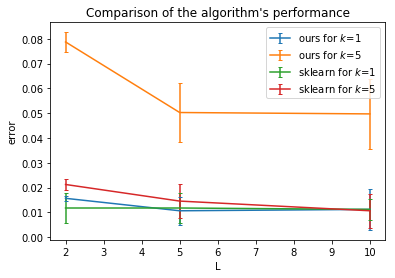

In [78]:
for i in range(4):
    plt.errorbar([2,5,10],Error[i],yerr=delError[i],capsize=2,label='%s for $k$=%i'%(['ours','sklearn'][i//2],[1,5][i%2]))
plt.title("Comparison of the algorithm's performance")
plt.xlabel('L')
plt.ylabel('error')
plt.legend()
plt.show()

The errors are decreasing with L and increasing with k. Our implementation is not as good as the $\texttt{sklearn}$'s implementation.

<span style =" color : green ;font-weight : bold ">Our classifier did not return the same results as sklearn. We already elaborated why this is. </span >